# Individually identifying songs of Great Tits (*Parus major*)

The Great Tit (*Parus major*) is known for its varied song repertoire. Seventy song types are known, with each individual's repertoire including up to eight song types. 

<center><img src="https://i.guim.co.uk/img/media/b98326a736e0c4e5d88846102bef16414b6450a5/0_0_4960_2976/master/4960.jpg?width=1200&height=900&quality=85&auto=format&fit=crop&s=b693c659d0b233d394e2fa3e28863701" alt="Great Tit (Parus major) singing" width="300" /></center>

In this exercise we will be working with the [Wytham Great Tit Song Dataset](https://nilomr.github.io/great-tit-hits/), which includes a large amount of Great Tit songs recorded in the wild. Each burst of song is identified by the individual that sung it as well as by the song type.

We will inspect a handful of examples from each individual, with all examples belonging to the same song type for that individual. Using a pretrained convolutional neural network, we will generate feature embeddings for the spectrogram of each song, then use t-SNE to cluster these embeddings. We will see that the convolutional neural network picks up on enough distinctive features of each song to allow us to cluster them well by individual.

## Import packages

This notebook should be run in an environment containing OpenSoundscape (see instructions for your system [here](https://opensoundscape.readthedocs.io/en/latest/index.html)) and `tensorflow-cpu`.

Alternatively, you may install them on a Google Colab notebook using the cell below:

In [1]:
# if this is a Google Colab notebook, install opensoundscape in the runtime environment
if 'google.colab' in str(get_ipython()):
  %pip install opensoundscape==0.10.1
  %pip install tensorflow-cpu

The following cell make take a while...!

In [2]:
import pandas as pd
import json
from pathlib import Path
from opensoundscape.audio import Audio
from opensoundscape.spectrogram import Spectrogram
import torch

/Users/tessa/opt/anaconda3/envs/opso-dev/lib/python3.9/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Download files

* Open our Google Drive folder here: https://drive.google.com/drive/u/0/folders/1-XOEcKHOSiDSIlSHElOeJY5Jza4Hc-7v
* Download the two files (`wytham_annotations.csv` and `wytham_songs.zip`)
* Unzip the zip folder
* Place the files into a folder of your choosing and write the folders below:

In [3]:
wav_folder = "/Users/tessa/Code/scratchpad/acoustic-communication-and-bioacoustics-bootcamp/code/wytham_songs/"
csv_path = "/Users/tessa/Code/scratchpad/acoustic-communication-and-bioacoustics-bootcamp/code/wytham_annotations.csv"

## Load data

In [4]:
# Wavfiles from subset of the Wytham Great Tit dataset
wavfiles = list(Path(wav_folder).glob("*.wav"))
wavfiles = sorted(wavfiles)

Now, get the data on what individual produced each sound. Subset it to only include the subset of recordings we downloaded.

In [5]:
annots_df = pd.read_csv(csv_path, index_col=0)


The ID column contains individual IDs. How many individual IDs are in it? What does this dataframe look like?

In [6]:
print("Number of individuals:", len(annots_df.ID.unique()))
annots_df.head()

Number of individuals: 42


,ID,class_id,datetime,start,end,length_s,bit_rate,sample_rate,lower_freq,upper_freq,max_amplitude,onsets,offsets,silence_durations,unit_durations
20201EX14_20200420_040000_100535175,20201EX14,20201EX14_0,2020-04-20 04:34:54.482812500,100535175,100649383,2.379365,768000,22050,3113,4754,0.476932,"[0.4992290249433107, 0.7198185941043084, 0.969...","[0.6443537414965986, 0.7836734693877551, 1.108...","[0.07546485260770974, 0.18575963718820865, 0.0...","[0.14512471655328796, 0.06385487528344669, 0.1..."
20201EX14_20200420_040000_100887839,20201EX14,20201EX14_0,2020-04-20 04:35:01.829979167,100887839,101025892,2.876145,768000,22050,3159,4870,0.544844,"[0.49342403628117915, 0.7024036281179138, 0.95...","[0.6385487528344671, 0.7836734693877551, 1.131...","[0.06385487528344669, 0.1741496598639456, 0.04...","[0.14512471655328796, 0.08126984126984127, 0.1..."
20201EX14_20200420_040000_101204309,20201EX14,20201EX14_0,2020-04-20 04:35:08.423104167,101204309,101347382,2.980726,768000,22050,3252,4731,0.501223,"[0.6501587301587302, 0.8591383219954648, 1.091...","[0.7952834467120181, 0.9346031746031747, 1.259...","[0.06385487528344669, 0.1567346938775509, 0.05...","[0.14512471655328796, 0.07546485260770985, 0.1..."
20201EX14_20200420_040000_101518066,20201EX14,20201EX14_0,2020-04-20 04:35:14.959708333,101518066,101674945,3.268345,768000,22050,3183,4685,0.597881,"[0.6965986394557823, 0.905578231292517, 1.1435...","[0.8417233560090703, 0.9520181405895691, 1.300...","[0.06385487528344669, 0.19156462585034006, 0.0...","[0.14512471655328807, 0.04643990929705211, 0.1..."
20201EX14_20200420_040000_101795427,20201EX14,20201EX14_0,2020-04-20 04:35:20.738062500,101795427,101924695,2.693107,768000,22050,3298,4777,0.465838,"[0.46439909297052157, 0.6849886621315193, 0.92...","[0.626938775510204, 0.7604535147392291, 1.1029...","[0.05804988662131527, 0.16834467120181407, 0.0...","[0.16253968253968248, 0.07546485260770974, 0.1..."


In [7]:
import ast
# Get the annotated data for all these wavfiles
wavfile_ids = [str(wavfile.name).strip(".wav").strip(".WAV") for wavfile in wavfiles]
annots_df = pd.read_csv(
    csv_path, index_col=0,
    # If you want to use individual syllable data, need to convert some columns to lists
    #converters={12:ast.literal_eval, 13:ast.literal_eval, 14:ast.literal_eval, 15:ast.literal_eval}
)
annots_df = annots_df.loc[wavfile_ids]
print(annots_df.shape[0])

8667


Let's start by just looking at a small amount of songs from a handful of individuals. 

Each individual sings multiple song types (in the `class_id` column), so let's control for different song types by only looking at songs from an individual that are of the same song type as each other.

Let's get the 20 most-recorded song types per individual.

In [8]:
# Top 20 most common song types, removing any duplicate individual IDs
top_song_types = annots_df.value_counts(["ID", "class_id"]).reset_index().drop_duplicates("ID")[:20]
top_song_types

,ID,class_id,count
0,20201SW5,20201SW5_1,413
1,20211EX62F,20211EX62F_0,397
2,20201O81,20201O81_1,362
3,20211O115,20211O115_2,351
4,20201W12,20201W12_0,316
5,20211EX76,20211EX76_2,315
6,20211EX62C,20211EX62C_0,296
7,20211MP12,20211MP12_0,286
8,20201MP61,20201MP61_2,283
9,20201W37,20201W37_3,243


Get 20 random examples of each song type to work with

In [9]:
# Get all annotations for these songtypes
all_annots_songtypes = annots_df[annots_df.class_id.isin(top_song_types.class_id.values)]

# Randomly sample 20 recordings per song type"
test_songs = all_annots_songtypes.groupby("class_id").sample(20, random_state=3)

# Make sure there are 20 per song type
test_songs.class_id.value_counts()

class_id
20201MP34_1     20
20201MP61_2     20
20211O112_0     20
20211MP98_2     20
20211MP52_1     20
20211MP12_0     20
20211EX76_2     20
20211EX62F_0    20
20211EX62E_3    20
20211EX62C_0    20
20211C26_1      20
20211B86_0      20
20201W37_3      20
20201W12_0      20
20201SW5_1      20
20201O81_1      20
20201O27A_0     20
20201MP68_0     20
20201MP67_1     20
20211O115_2     20
Name: count, dtype: int64

Let's visualize an example using OpenSoundscape:

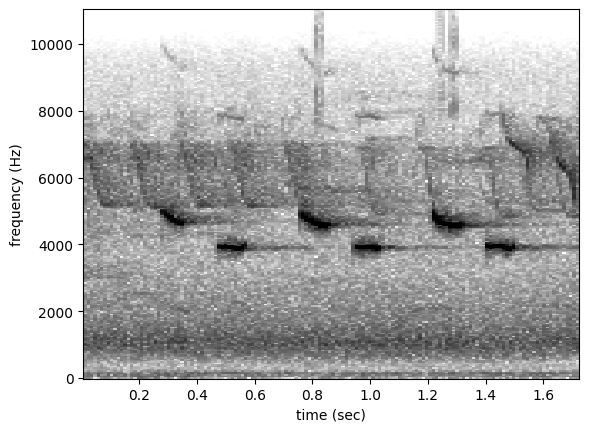

In [10]:
# Get a single song ID
idx = 1
song_id = test_songs.index[idx]
annots = test_songs.loc[song_id]
wavfile = Path(wav_folder + song_id + ".wav")

# Load the audio of this song
individ_audio = Audio.from_file(wavfile)

# View and listen to the song
Spectrogram.from_audio(individ_audio).plot()
individ_audio.show_widget()

There's a lot of noise in the recording. One way we could explore noise reduction is to load this file bandpassed.

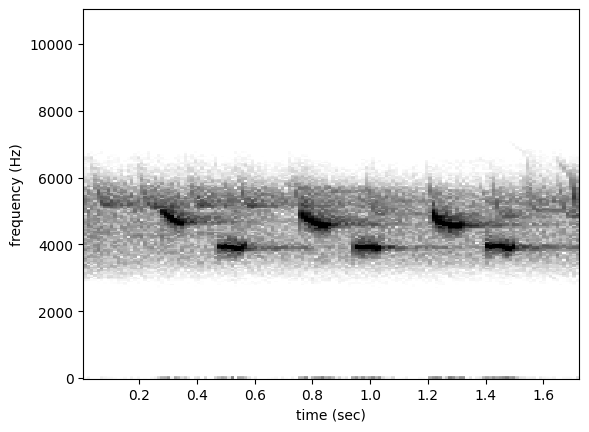

In [11]:
individ_audio = Audio.from_file(wavfile).bandpass(annots.lower_freq, annots.upper_freq, order=4)
Spectrogram.from_audio(individ_audio).plot()

## Generate embeddings

Now let's load a model we can use to generate unsupervised feature embeddings for recordings

In [12]:
import torch
m = torch.hub.load('kitzeslab/bioacoustics-model-zoo', 'BirdNET',trust_repo=True)

Using cache found in /Users/tessa/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main
2024-05-07 11:25:40.440481: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


downloading model from URL...
Downloaded completed: BirdNET_GLOBAL_6K_V2.4_Model_FP16.tflite


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


Downloaded completed: BirdNET_GLOBAL_6K_V2.4_Labels_af.txt


Use the model to generate embeddings for all of the recordings

In [13]:
test_wavfiles = [wav_folder + song_id + ".wav" for song_id in test_songs.index]

wavfiles_df = pd.DataFrame(test_wavfiles)
wavfiles_df.columns = ["file"]
wavfiles_df["start_time"] = 0
wavfiles_df["end_time"] = 3
wavfiles_df = wavfiles_df.set_index(["file", "start_time", "end_time"])

In [14]:
%%time
%%capture --no-stdout
# This will raise many warnings due to the differing 
# lengths of the wavfiles, so in this cell we catch all output
embeddings = m.generate_embeddings(wavfiles_df)

CPU times: user 22.8 s, sys: 493 ms, total: 23.3 s
Wall time: 23.9 s


Use t-SNE to dimensionally reduce the embeddings

In [15]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
embeddings_tsne = tsne.fit_transform(embeddings)

/Users/tessa/opt/anaconda3/envs/opso-dev/lib/python3.9/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Plot the embeddings by individual number

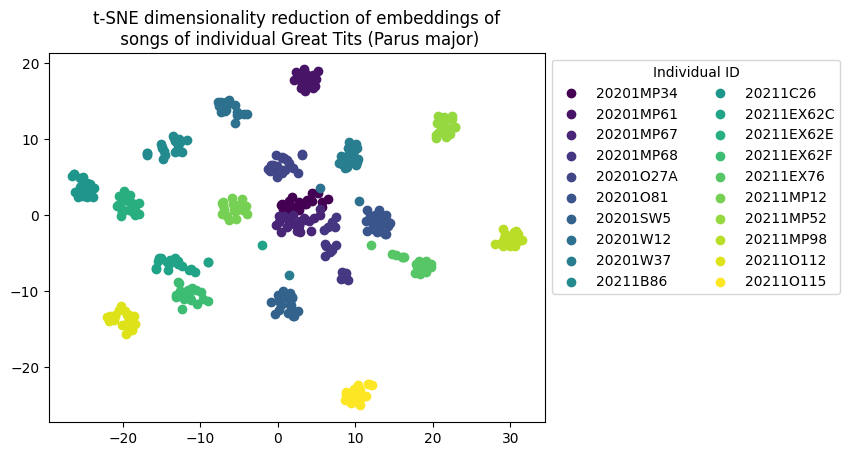

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
fig, ax = plt.subplots()

individual_ids = test_songs.ID
color_map = iter(cm.viridis(np.linspace(0, 1, len(individual_ids.unique()))))
for i, individual_idx in enumerate(np.unique(individual_ids)):
    color = next(color_map)
    embeddings_individual = embeddings_tsne[individual_ids == individual_idx]
    ax.scatter(embeddings_individual[:, 0], y=embeddings_individual[:, 1], label=individual_idx, color=color)
ax.legend(ncols=2, bbox_to_anchor=(1, 1), title="Individual ID")
plt.title("t-SNE dimensionality reduction of embeddings of\n songs of individual Great Tits (Parus major)")
plt.show()

This looks fantastic, though not perfect!

Let's see what each of these individual's songs actually look like!

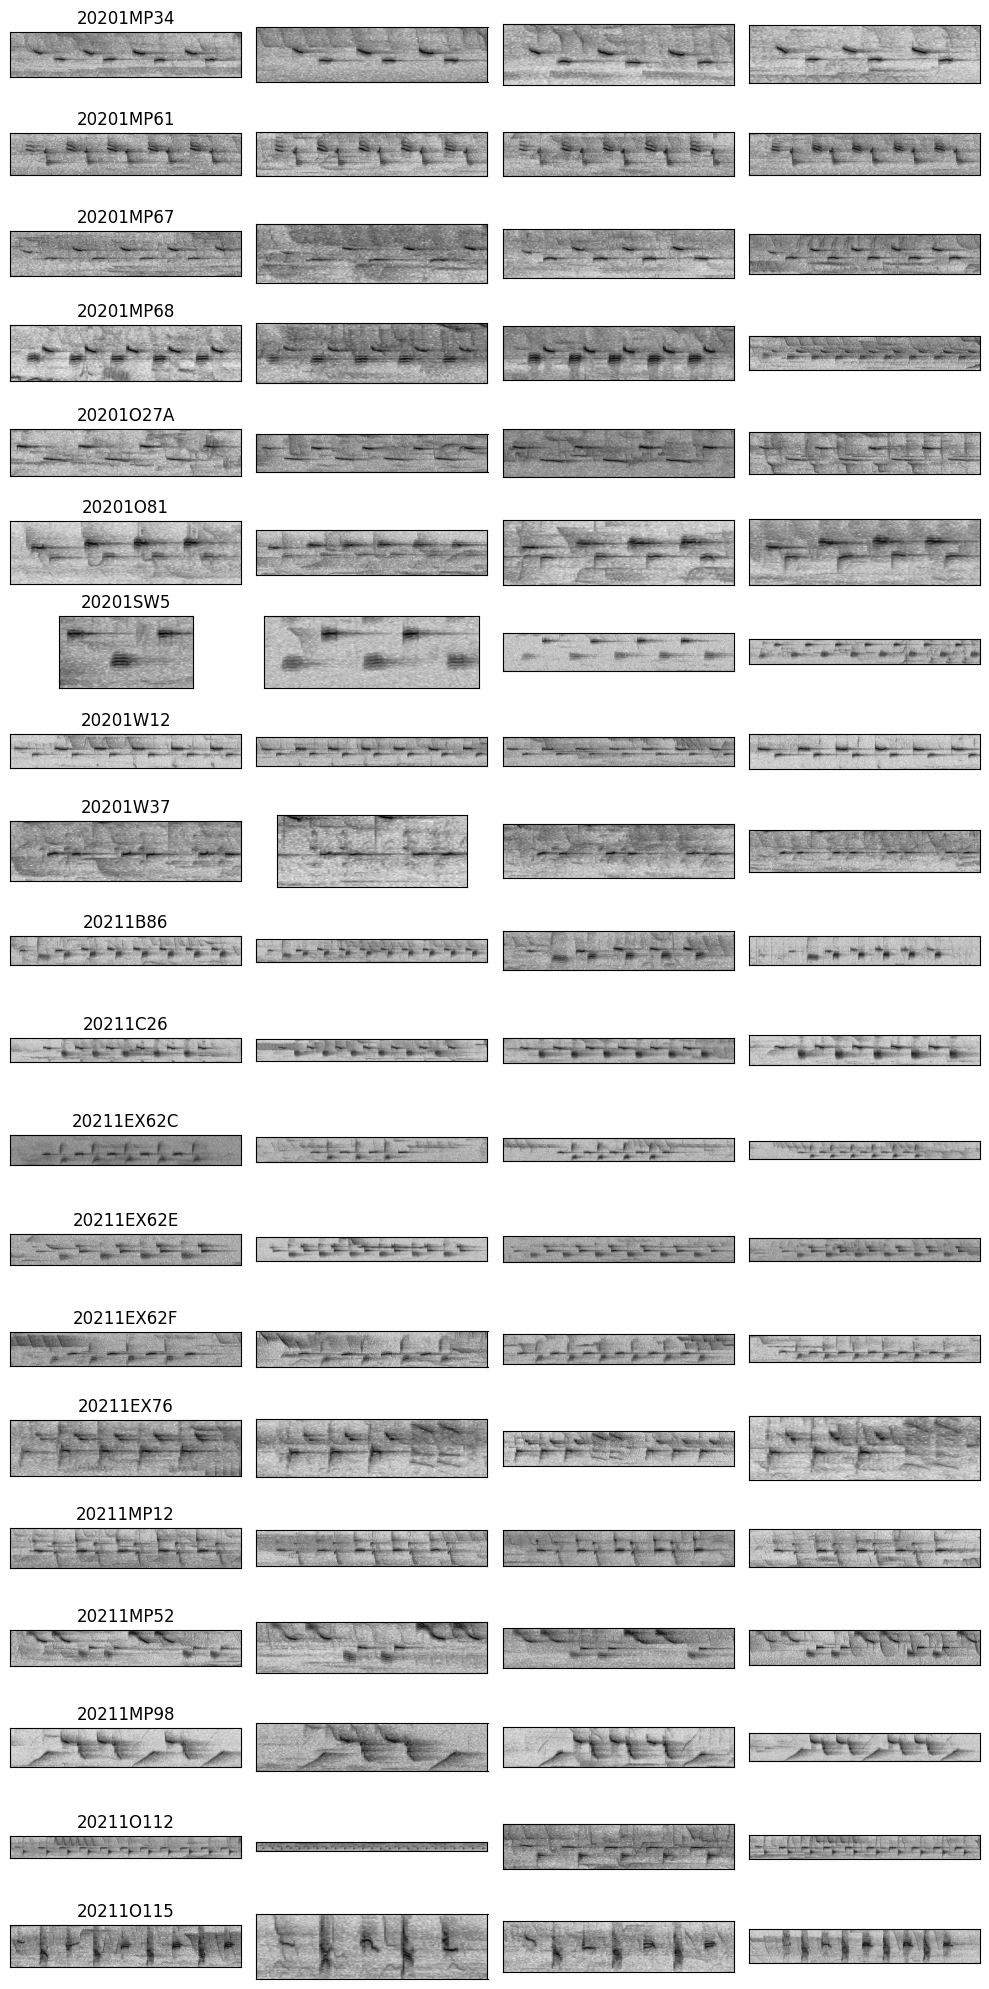

In [17]:
songs_plot_per_individual = 4
fig, axs = plt.subplots(20, songs_plot_per_individual, figsize=(10,20))
for individual_idx, (individual_id, df) in enumerate(test_songs.groupby(["ID"])):
    for song_idx, song_id in enumerate(df.index[:songs_plot_per_individual]):
        # Get the axis in the correct position
        _ = plt.sca(axs[individual_idx, song_idx])
        ax = plt.gca()
        
        # Get the spectrogram and plot it
        s = Spectrogram.from_audio(Audio.from_file(wav_folder + song_id + ".wav")).bandpass(2000,7000).spectrogram
        _ = plt.imshow(s, aspect=0.3, cmap="Greys")
        ax.invert_yaxis() # When using imshow, have to invert this
        
        # Nice formatting
        # Hide X and Y axes label marks
        ax.xaxis.set_tick_params(labelbottom=False)
        ax.yaxis.set_tick_params(labelleft=False)
        # Hide X and Y axes tick marks
        ax.set_xticks([])
        ax.set_yticks([])
        if song_idx == 0:
            ax.set_title(individual_id[0])
plt.tight_layout()

# Potential next steps

## Improving clustering

One of the biggest challenges of clustering the sounds of wild animals is that other noises overlapping the sound can affect clustering performance. Some options for noise reduction include:
* Modifying the pipeline to bandpass the recordings to the annotated range
* Applying noise reduction using the Python `noisereduce` package (doesn't work as well on short recordings) or the [Google MixIT bird separation model](https://github.com/kitzeslab/bioacoustics-model-zoo?tab=readme-ov-file#mixit-bird-separationmodel) implemented in OpenSoundscape

## Inspecting similar song types across individuals

The subset of recordings includes the song most commonly sung for 42 individuals in "part 1" of the Great Tit dataset. Over 70 different song types are known, with an individual singing up to eight different song types. While "song types" are each very different from each other, two different individuals singing the same song type might actually sound quite similar.

A future approach could be to select a song type that many individuals use, and see if individuals can still be identified by the particular quirks in how they sing that song type!